# "Chat" Stats

# Imports

In [1]:
import csv
import os
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import re
import string, timeit
from collections import defaultdict
import operator
import gensim
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
import plotly_express as px
import plotly_express.colors.colorbrewer as pxc
import datetime as dt
from dateutil import parser

%matplotlib inline
%config InLineBackend.figure_format = 'retina'

sns.set_style('whitegrid')


C:\Users\Corey Moser\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Find the path and the file and create an absolute link to it

In [21]:
#Get the directory, the filename and combine the two
directory = r'C:\Users\Corey Moser\Documents\Programming\Python\My_Projects\CabalStats'+'\\'
the_chat = "KehuiHu.txt"
full_path = directory+the_chat

In [22]:
# Print the first five lines each with a line numbering 

counter = 10
with open(full_path, encoding='utf-8', mode ='r') as f:
    for cnt, line in enumerate(f):
        print("Line {}: {}".format(cnt,line))
        counter -= 1 
        if counter == 0:
            break

Line 0: 9/14/18, 2:43 PM - Messages to this chat and calls are now secured with end-to-end encryption. Tap for more info.

Line 1: 9/14/18, 2:43 PM - Corey Moser: Hey Kehui, the next time you're working on Alix data I'd love to sit with you so I can get a better sense of how you approach the problem

Line 2: 9/14/18, 2:43 PM - Corey Moser: I know it might not be feasible everytime but I really want to learn and get better at Jupyter

Line 3: 9/14/18, 2:47 PM - Kehui Hu: No problem! I can also learn English from you at the same time. And I am writing explanations on the jupytor code and will send it to you. If you have problems with the content, feel free to tell me:)

Line 4: 9/14/18, 2:48 PM - Corey Moser: I would be happy to practice english with you any time you want! But seriously whenever you're planning to work on Jupyter let me know. I'm near campus so I can come to you or meet you at school whenever works. I'm happy to work evenings/weekends too so whatever works with your sche

# Functions 

<b><em>Opn</em> function opens a text file</b>

In [23]:
def opn(file_name):
    '''
    Transforms a text file to a list where each chat post is another item in the list.
    input: str. path to the chapter file
    output: a list containing each line of the text as a list
    '''
    with open(file_name, encoding='utf-8', mode ='r') as file:
        l = []
        for line in file:
            l.append(line.rstrip('\n'))
    return l

<b>How many lines, or messages, are in the file? 

In [24]:
len(opn(full_path)) 

183

<b>The code below opens the entire file. Avoid running for now; unnecessary use of RAM</b>

In [14]:
# opn(full_path)

<b>There are two version of this function because the WhatsApp.txt file exports the text in different formats. Version 2 is  better because it uses regex, which is more reliable, to identify the date, time user and message. At some point I may rewrite version 1 of <em>transform to data</em> to use regex too.</b>

In [25]:
def transform_to_data(file_name):
    '''
    Generates a list of ordered tuples (date, time, user name, message/post content).
    Input: A file name
    Output: A list of ordered tuples e.g. [(date, time, user, message),
                                            (date, time, user, message)]
    '''
    
    date_lst = []
    time_lst = []
    user_lst = []
    message_lst =[]

    comma_partition, dash_partition, colon_partition  = ",", "-", ":"
    
#     text_file_as_list = opn(file_name)
    for i in opn(file_name):
        date, comma, rest_of_message = i.partition(comma_partition)
        date_lst.append(date.strip())

        time, dash, rest_of_message = rest_of_message.partition(dash_partition)
        time_lst.append(time.strip())

        name, colon, post_content = rest_of_message.partition(colon_partition)
        user_lst.append(name.strip())
        message_lst.append(post_content.strip())
    
    return list(zip(date_lst, time_lst, user_lst, message_lst))

    

In [26]:
def transform_to_data_v2(file_name):
    '''
    Same as below but this version uses regex to extract the values.
    '''
    date_lst = []
    time_lst = []
    user_lst = []
    message_lst =[]
    
    for i in opn(file_name):
        date_time = str(re.findall(r'\[(.*?)\]',i))
        date = str(re.findall(r'\[(.*?),',date_time))
        date = date.lstrip("[").rstrip("]")
        date = date.replace('"', '')
        date = date.replace("'", '')
        date = date.strip()
        date_lst.append(date)
        
        time = str(re.findall(r',(.*?)\]',i))
        time = time.lstrip("[").rstrip("]")
        time = time.replace('"', '')
        time = time.replace("'", '')
        time = time.strip()
        time_lst.append(time)
        
        #User
        try:
            user = str(re.findall(r'\](.*?):',i))
            user = user.lstrip('[').rstrip(']')
            user = user.replace("'", '')
            user = user.strip()
            user_lst.append(user)
        except:
            user='User Unknown'

        #Message
        try:
            msg = str(re.findall(r':\s(.*$)',i))
            msg = msg.lstrip('[').rstrip(']')
            msg = msg.replace("'", '')
            msg = msg.lstrip('"').rstrip('"')
            msg = msg.lstrip("'").rstrip("'")
            message_lst.append(msg)
        except:
            msg = 'No Message'
        
    return list(zip(date_lst, time_lst, user_lst, message_lst))

<b>Come back to this code below and functionalize</b>

In [27]:
df = pd.DataFrame() #Initialize a dataframe

#Append each row to our data df
append_me = pd.DataFrame(data = transform_to_data(full_path), columns = ['Date', 'Time', 'User', 'Message'])
df = df.append(append_me, ignore_index=True)

In [28]:
df

Date      Time                                               User  \
0    9/14/18   2:43 PM  Messages to this chat and calls are now secure...   
1    9/14/18   2:43 PM                                        Corey Moser   
2    9/14/18   2:43 PM                                        Corey Moser   
3    9/14/18   2:47 PM                                           Kehui Hu   
4    9/14/18   2:48 PM                                        Corey Moser   
5    9/14/18   2:58 PM                                           Kehui Hu   
6    9/14/18   3:01 PM                                        Corey Moser   
7    9/14/18   3:03 PM                                           Kehui Hu   
8    9/14/18   3:05 PM                                        Corey Moser   
9    9/17/18   1:07 PM                                           Kehui Hu   
10   9/17/18   1:08 PM                                        Corey Moser   
11   9/17/18   1:15 PM                                           Kehui Hu   
12   9/17/18   1:16 PM                                        Corey Moser   
13   9/17/18   1:17 PM                                           Kehui Hu   
14   9/17/18   1:20 PM                                        Corey Moser   
15   9/17/18   1:22 PM                                           Kehui Hu   
16   9/17/18   1:22 PM                                        Corey Moser   
17   9/17/18   1:22 PM                                           Kehui Hu   
18   9/17/18   1:25 PM                                        Corey Moser   
19   9/18/18  10:31 AM                                           Kehui Hu   
20   9/18/18   1:39 PM                                           Kehui Hu   
21   9/18/18   1:40 PM                                           Kehui Hu   
22   9/18/18   2:44 PM                                        Corey Moser   
23   9/19/18   2:00 PM                                        Corey Moser   
24   9/19/18   2:35 PM                                           Kehui Hu   
25   9/19/18   2:39 PM                                        Corey Moser   
26   9/30/18  10:24 PM                                        Corey Moser   
27   9/30/18  10:25 PM                                        Corey Moser   
28   9/30/18  10:27 PM                                           Kehui Hu   
29   9/30/18  10:28 PM                                           Kehui Hu   
..       ...       ...                                                ...   
153  3/12/19   3:33 PM                                        Corey Moser   
154  3/19/19   7:59 PM                                           Kehui Hu   
155  3/19/19  11:12 PM                                        Corey Moser   
156  3/19/19  11:28 PM                                           Kehui Hu   
157  3/19/19  11:31 PM                                        Corey Moser   
158  3/19/19  11:32 PM                                           Kehui Hu   
159  3/19/19  11:40 PM                                        Corey Moser   
160  3/19/19  11:41 PM                                           Kehui Hu   
161  3/19/19  11:42 PM                                           Kehui Hu   
162  3/19/19  11:43 PM                                           Kehui Hu   
163  3/19/19  11:44 PM                                        Corey Moser   
164  3/19/19  11:48 PM                                           Kehui Hu   
165  3/19/19  11:48 PM                                           Kehui Hu   
166  3/19/19  11:48 PM                                        Corey Moser   
167  3/19/19  11:49 PM                                           Kehui Hu   
168  3/19/19  11:49 PM                                           Kehui Hu   
169  3/19/19  11:50 PM                                        Corey Moser   
170  3/19/19  11:50 PM                                        Corey Moser   
171  3/19/19  11:50 PM                                           Kehui Hu   
172  3/19/19  11:50 PM                                           Kehui Hu   
173 

# Save or Load the DataFrame 

<b>Save df as a .csv or load an already-saved .csv as a df 

In [16]:
# df.to_csv('KehuiChat.csv', index=False)

In [3]:
# df = pd.read_csv(r'C:\Users\Corey Moser\Documents\Programming\Python\My_Projects\CabalStats\KehuiChat.csv')  # doctest: +SKIP


# Preprocessing and Discovery

In [30]:
print(f"The shape of the df is: {df.shape}")
print()
print(df.info())

The shape of the df is: (183, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 4 columns):
Date       183 non-null object
Time       183 non-null object
User       183 non-null object
Message    183 non-null object
dtypes: object(4)
memory usage: 5.8+ KB
None


## User Cleanup

In [34]:
user_list = [df['User'].unique()]
user_list

[array(['Messages to this chat and calls are now secured with end-to-end encryption. Tap for more info.',
        'Corey Moser', 'Kehui Hu'], dtype=object)]

In [33]:
df[df['User'] == "Messages to this chat and calls are now secured with end-to-end encryption. Tap for more info."]

Date     Time                                               User Message
0  9/14/18  2:43 PM  Messages to this chat and calls are now secure...

In [35]:
df = df.drop(df[(df['User'] == 'Messages to this chat and calls are now secured with end-to-end encryption. Tap for more info.')].index)

In [36]:
user_list = [df['User'].unique()]
user_list

[array(['Corey Moser', 'Kehui Hu'], dtype=object)]

# Analysis 1: Most/Least Posts

## Post Count

In [37]:
most_posts = df['User'].value_counts()
most_posts

Kehui Hu       97
Corey Moser    85
Name: User, dtype: int64

<b>Plot the data using Matplotlib</b>

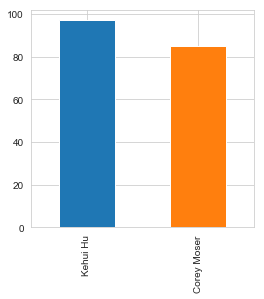

In [43]:
most_posts.plot(kind='bar', figsize=(4,4))

<b>Plot the data again use Plotly Express (imported as px)</b>

In [45]:
df_most_posts = most_posts.reset_index().rename(columns={'index':'User', 'User':'Num_Msg'})

In [46]:
df_most_posts.head()

User  Num_Msg
0     Kehui Hu       97
1  Corey Moser       85

In [47]:
px.bar(df_most_posts, x='Num_Msg', y='User', 
       orientation='h',
       title = 'Most/Least Posts',
       hover_name='Num_Msg',
       text='Num_Msg',
       color_discrete_sequence= pxc.Pastel2,
      )

## Most/least frequent poster as a percentage of total posts


In [49]:
most_posts_freq = df['User'].value_counts(normalize=True)
df_post_pct= most_posts_freq.reset_index().rename(columns={'index':'User','User':'Pct_Total'})
most_posts_freq = df_post_pct.sort_values(by=['Pct_Total'], ascending=False)

most_posts_freq['Pct_Total'] = most_posts_freq['Pct_Total'].astype(np.float32).apply("{0:.1%}".format)
most_posts_freq

User Pct_Total
0     Kehui Hu     53.3%
1  Corey Moser     46.7%

In [51]:
px.bar(most_posts_freq, x='User', y='Pct_Total', orientation='v',
       title = 'Most/Least Posts as a Percentage of all Posts',
       hover_name='Pct_Total',
       text='Pct_Total',
       labels={'Pct_Total':"Percentage of Total Messages Sent", "User":'Users'},
       color='User',
      )

# Analyis 2: Length of messages

<b>Run below if nltk library gives you issues</b>

In [112]:
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')

<b>Create a new column, <em>free_message</em> which lowercases all words and removes 32 common punctuations (imported from the string library) as shown below</b>

In [52]:
string.punctuation

for i, c in enumerate(string.punctuation):
    print(f"{i} - {c} ", end='')

0 - ! 1 - " 2 - # 3 - $ 4 - % 5 - & 6 - ' 7 - ( 8 - ) 9 - * 10 - + 11 - , 12 - - 13 - . 14 - / 15 - : 16 - ; 17 - < 18 - = 19 - > 20 - ? 21 - @ 22 - [ 23 - \ 24 - ] 25 - ^ 26 - _ 27 - ` 28 - { 29 - | 30 - } 31 - ~ 

In [53]:
df.head()

Date     Time         User  \
1  9/14/18  2:43 PM  Corey Moser   
2  9/14/18  2:43 PM  Corey Moser   
3  9/14/18  2:47 PM     Kehui Hu   
4  9/14/18  2:48 PM  Corey Moser   
5  9/14/18  2:58 PM     Kehui Hu   

                                             Message  
1  Hey Kehui, the next time you're working on Ali...  
2  I know it might not be feasible everytime but ...  
3  No problem! I can also learn English from you ...  
4  I would be happy to practice english with you ...  
5  Thanks a lot, You are so nice! I am now at hom...

In [54]:
punct = set(string.punctuation)

#Free of punctiations dialogue
df['free_message']= df['Message'].apply(lambda x :''.join(ch.lower() for ch in x if ch not in punct))

In [55]:
df.head(n=5)

Date     Time         User  \
1  9/14/18  2:43 PM  Corey Moser   
2  9/14/18  2:43 PM  Corey Moser   
3  9/14/18  2:47 PM     Kehui Hu   
4  9/14/18  2:48 PM  Corey Moser   
5  9/14/18  2:58 PM     Kehui Hu   

                                             Message  \
1  Hey Kehui, the next time you're working on Ali...   
2  I know it might not be feasible everytime but ...   
3  No problem! I can also learn English from you ...   
4  I would be happy to practice english with you ...   
5  Thanks a lot, You are so nice! I am now at hom...   

                                        free_message  
1  hey kehui the next time youre working on alix ...  
2  i know it might not be feasible everytime but ...  
3  no problem i can also learn english from you a...  
4  i would be happy to practice english with you ...  
5  thanks a lot you are so nice i am now at home ...

In [56]:
#We create a tokenize variable of the free_message column to separate the words and count them
df['tokenized_message'] = df.apply(lambda row: nltk.word_tokenize(row['free_message']), axis=1)

In [57]:
df.head(n=5)

Date     Time         User  \
1  9/14/18  2:43 PM  Corey Moser   
2  9/14/18  2:43 PM  Corey Moser   
3  9/14/18  2:47 PM     Kehui Hu   
4  9/14/18  2:48 PM  Corey Moser   
5  9/14/18  2:58 PM     Kehui Hu   

                                             Message  \
1  Hey Kehui, the next time you're working on Ali...   
2  I know it might not be feasible everytime but ...   
3  No problem! I can also learn English from you ...   
4  I would be happy to practice english with you ...   
5  Thanks a lot, You are so nice! I am now at hom...   

                                        free_message  \
1  hey kehui the next time youre working on alix ...   
2  i know it might not be feasible everytime but ...   
3  no problem i can also learn english from you a...   
4  i would be happy to practice english with you ...   
5  thanks a lot you are so nice i am now at home ...   

                                   tokenized_message  
1  [hey, kehui, the, next, time, youre, working, ...  
2  [i, know, it, might, not, be, feasible, everyt...  
3  [no, problem, i, can, also, learn, english, fr...  
4  [i, would, be, happy, to, practice, english, w...  
5  [thanks, a, lot, you, are, so, nice, i, am, no...

<b>Number of words per message</b>

In [58]:
df['number_of_words'] = df.tokenized_message.apply(lambda x: len(x))

In [59]:
df.head(n=5)

Date     Time         User  \
1  9/14/18  2:43 PM  Corey Moser   
2  9/14/18  2:43 PM  Corey Moser   
3  9/14/18  2:47 PM     Kehui Hu   
4  9/14/18  2:48 PM  Corey Moser   
5  9/14/18  2:58 PM     Kehui Hu   

                                             Message  \
1  Hey Kehui, the next time you're working on Ali...   
2  I know it might not be feasible everytime but ...   
3  No problem! I can also learn English from you ...   
4  I would be happy to practice english with you ...   
5  Thanks a lot, You are so nice! I am now at hom...   

                                        free_message  \
1  hey kehui the next time youre working on alix ...   
2  i know it might not be feasible everytime but ...   
3  no problem i can also learn english from you a...   
4  i would be happy to practice english with you ...   
5  thanks a lot you are so nice i am now at home ...   

                                   tokenized_message  number_of_words  
1  [hey, kehui, the, next, time, youre, working, ...               29  
2  [i, know, it, might, not, be, feasible, everyt...               19  
3  [no, problem, i, can, also, learn, english, fr...               40  
4  [i, would, be, happy, to, practice, english, w...               53  
5  [thanks, a, lot, you, are, so, nice, i, am, no...               34

<b>Number of characters per message</b>

In [60]:
def character_count(list_of_words):
    msg_len = 0
    for word in list_of_words:
        msg_len += (len(word))
    return msg_len

In [61]:
df['number_of_chars'] = df.apply(lambda row: character_count(row['tokenized_message']),axis=1)

In [62]:
df.head()

Date     Time         User  \
1  9/14/18  2:43 PM  Corey Moser   
2  9/14/18  2:43 PM  Corey Moser   
3  9/14/18  2:47 PM     Kehui Hu   
4  9/14/18  2:48 PM  Corey Moser   
5  9/14/18  2:58 PM     Kehui Hu   

                                             Message  \
1  Hey Kehui, the next time you're working on Ali...   
2  I know it might not be feasible everytime but ...   
3  No problem! I can also learn English from you ...   
4  I would be happy to practice english with you ...   
5  Thanks a lot, You are so nice! I am now at hom...   

                                        free_message  \
1  hey kehui the next time youre working on alix ...   
2  i know it might not be feasible everytime but ...   
3  no problem i can also learn english from you a...   
4  i would be happy to practice english with you ...   
5  thanks a lot you are so nice i am now at home ...   

                                   tokenized_message  number_of_words  \
1  [hey, kehui, the, next, time, youre, working, ...               29   
2  [i, know, it, might, not, be, feasible, everyt...               19   
3  [no, problem, i, can, also, learn, english, fr...               40   
4  [i, would, be, happy, to, practice, english, w...               53   
5  [thanks, a, lot, you, are, so, nice, i, am, no...               34   

   number_of_chars  
1              106  
2               76  
3              155  
4              228  
5              125

In [63]:
num_words_df = df.groupby('User')['number_of_words'].sum().sort_values(ascending=False).reset_index()
num_words_df.head()

User  number_of_words
0     Kehui Hu             1128
1  Corey Moser             1037

<b>Merge this with our previous df</b>

In [64]:
df_merge = pd.merge(df_most_posts,num_words_df)
df_merge.head()

User  Num_Msg  number_of_words
0     Kehui Hu       97             1128
1  Corey Moser       85             1037

In [65]:
df_merge['words_per_msg'] = df_merge['number_of_words']/df_merge['Num_Msg']
df_merge

User  Num_Msg  number_of_words  words_per_msg
0     Kehui Hu       97             1128      11.628866
1  Corey Moser       85             1037      12.200000

In [66]:
px.scatter(df_merge, x='Num_Msg', y='number_of_words',
          color='User', trendline='ols', size='words_per_msg', text='User',
          title = 'Number of Message Sent v. Total Number of Words',
          labels ={'number_of_words': 'Total Words', "Num_Msg":'Total Messages Sent'})

In [67]:
df_merge['avg_words_per_msg_rounded'] = round(df_merge['words_per_msg'],3)

In [68]:
df_merge.sort_values(['avg_words_per_msg_rounded'], ascending=False)

User  Num_Msg  number_of_words  words_per_msg  \
1  Corey Moser       85             1037      12.200000   
0     Kehui Hu       97             1128      11.628866   

   avg_words_per_msg_rounded  
1                     12.200  
0                     11.629

In [69]:
df_merge2 = df_merge.sort_values(['avg_words_per_msg_rounded'], ascending=False)
df_merge2.index =range(len(df_merge2.index))

In [70]:
df_merge2

User  Num_Msg  number_of_words  words_per_msg  \
0  Corey Moser       85             1037      12.200000   
1     Kehui Hu       97             1128      11.628866   

   avg_words_per_msg_rounded  
0                     12.200  
1                     11.629

In [71]:
user_list = df_merge2['User'].tolist()
user_list

['Corey Moser', 'Kehui Hu']

In [72]:
df_merge2 = df_merge2.round(3)
df_merge2

User  Num_Msg  number_of_words  words_per_msg  \
0  Corey Moser       85             1037         12.200   
1     Kehui Hu       97             1128         11.629   

   avg_words_per_msg_rounded  
0                     12.200  
1                     11.629

In [73]:
df_merge2.mean()

User                         (3.115210352129889e-307+2.3364837318251926e-307j)
Num_Msg                                                                (91+0j)
number_of_words                                                    (1082.5+0j)
words_per_msg                                                     (11.9145+0j)
avg_words_per_msg_rounded                                         (11.9145+0j)
dtype: complex128

In [74]:
px.bar(df_merge2, x='User', y='avg_words_per_msg_rounded', 
       orientation='v',
       title = 'Average Message Length',
       text='words_per_msg',
       color='User',
       labels ={'avg_words_per_msg_rounded': 'Average Words per Message ', "User":'Cabalsmen'},
       category_orders={"User": user_list}
      )

# Bag of words code

In [163]:
# filepath = 'Cabal_2018_0318.txt'

#Print each line out with a line numbering 

# with open(filepath, encoding='utf-8', mode ='r') as f:
#     for cnt, line in enumerate(f):
#         print("Line {}: {}".format(cnt,line))


#Make a bag of words
def ordered_bag_of_words(bag_of_words, desc=False):
    words = [(word, cnt) for word, cnt in bag_of_words.items()]
    return sorted(words, key=lambda x: x[1], reverse = desc)
        
#Record the word count
def record_word_cnt(words, bag_of_words):
    for word in words:
        if word != '':
            if word.lower() in bag_of_words:
                bag_of_words[word.lower()] +=1
            else:
                bag_of_words[word.lower()] =1



In [167]:
bag_of_words = {}
with open(full_path, encoding='utf-8') as fp:
    cnt = 0
    for line in fp:
#         print("line {} content {}". format(cnt,line))
        record_word_cnt(line.strip().split(' '), bag_of_words)
        cnt +=1
sorted_words = ordered_bag_of_words(bag_of_words, desc=True)
for word in sorted_words[:10]:
    print(word)
# print("Most frequent 10 words {}\\n".format(sorted_words[:100]),)

('the', 69865)
('matt', 57005)
('margolis:', 55888)
('i', 52456)
('amir', 51545)
('yimer:', 49833)
('a', 48922)
('to', 46863)
('eric', 41602)
('shalem:', 40889)


# Date Time Stuff

In [75]:
df.head()

Date     Time         User  \
1  9/14/18  2:43 PM  Corey Moser   
2  9/14/18  2:43 PM  Corey Moser   
3  9/14/18  2:47 PM     Kehui Hu   
4  9/14/18  2:48 PM  Corey Moser   
5  9/14/18  2:58 PM     Kehui Hu   

                                             Message  \
1  Hey Kehui, the next time you're working on Ali...   
2  I know it might not be feasible everytime but ...   
3  No problem! I can also learn English from you ...   
4  I would be happy to practice english with you ...   
5  Thanks a lot, You are so nice! I am now at hom...   

                                        free_message  \
1  hey kehui the next time youre working on alix ...   
2  i know it might not be feasible everytime but ...   
3  no problem i can also learn english from you a...   
4  i would be happy to practice english with you ...   
5  thanks a lot you are so nice i am now at home ...   

                                   tokenized_message  number_of_words  \
1  [hey, kehui, the, next, time, youre, working, ...               29   
2  [i, know, it, might, not, be, feasible, everyt...               19   
3  [no, problem, i, can, also, learn, english, fr...               40   
4  [i, would, be, happy, to, practice, english, w...               53   
5  [thanks, a, lot, you, are, so, nice, i, am, no...               34   

   number_of_chars  
1              106  
2               76  
3              155  
4              228  
5              125

<b>Cannot convert `Date` and `Time` to datetime objects because there are some bad values within. These values generally correspond to an unknown user so we will drop all of these columns </b>

In [76]:
# Get names of indexes for which User column value "User Unknown" 
index_names = df[df['User'] == 'User Unknown'].index
print(f"There are {len(index_names)} rows and the indices are:\n\n {index_names}")

There are 0 rows and the indices are:

 Int64Index([], dtype='int64')


In [77]:
# Create a df copy, then delete these row indexes from dataFrame
df_rows_dropped = df.copy()

In [78]:
df_rows_dropped.drop(index_names, inplace=True)

In [79]:
df_rows_dropped.shape

(182, 8)

<b>Convert the date column to a dt format</b>

In [80]:
df_rows_dropped['datetime'] = pd.to_datetime(df_rows_dropped['Date'])

<b>Create a new "Date_and_Time" column</b>

In [81]:
df_rows_dropped['Date_and_Time'] = df_rows_dropped['Date'] + " " + df_rows_dropped['Time']

In [82]:
df_rows_dropped.head()

Date     Time         User  \
1  9/14/18  2:43 PM  Corey Moser   
2  9/14/18  2:43 PM  Corey Moser   
3  9/14/18  2:47 PM     Kehui Hu   
4  9/14/18  2:48 PM  Corey Moser   
5  9/14/18  2:58 PM     Kehui Hu   

                                             Message  \
1  Hey Kehui, the next time you're working on Ali...   
2  I know it might not be feasible everytime but ...   
3  No problem! I can also learn English from you ...   
4  I would be happy to practice english with you ...   
5  Thanks a lot, You are so nice! I am now at hom...   

                                        free_message  \
1  hey kehui the next time youre working on alix ...   
2  i know it might not be feasible everytime but ...   
3  no problem i can also learn english from you a...   
4  i would be happy to practice english with you ...   
5  thanks a lot you are so nice i am now at home ...   

                                   tokenized_message  number_of_words  \
1  [hey, kehui, the, next, time, youre, working, ...               29   
2  [i, know, it, might, not, be, feasible, everyt...               19   
3  [no, problem, i, can, also, learn, english, fr...               40   
4  [i, would, be, happy, to, practice, english, w...               53   
5  [thanks, a, lot, you, are, so, nice, i, am, no...               34   

   number_of_chars   datetime    Date_and_Time  
1              106 2018-09-14  9/14/18 2:43 PM  
2               76 2018-09-14  9/14/18 2:43 PM  
3              155 2018-09-14  9/14/18 2:47 PM  
4              228 2018-09-14  9/14/18 2:48 PM  
5              125 2018-09-14  9/14/18 2:58 PM

In [83]:
#drop the now superfluous "datetime" column
df_rows_dropped.drop(['datetime'], axis=1, inplace=True)

In [84]:
# Set the "Date_and_Time" column as the index. Inplace = True overwrites the df with this as the index
df_rows_dropped.set_index('Date_and_Time', inplace=True)

In [88]:
df_rows_dropped.index[-1]

'4/8/19 6:20 PM'

<b>Chat takes places over 32 days, 33 minutes</b>

In [86]:
timespan = df_rows_dropped.index[-1] - df_rows_dropped.index[0] 
print(timespan)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

<b>These following two code cells both count the number of messages sent in a day</b>

In [87]:
#Code 1
df_rows_dropped.groupby(df_rows_dropped.index.date).count().head(n=10)

AttributeError: 'Index' object has no attribute 'date'

In [ ]:
#Code 2
df_rows_dropped.resample('D').apply({'Message':'count'}).head(n=10)

In [ ]:
msgs_per_day = df_rows_dropped.resample('D').apply({'Message':'count'}).reset_index()
msgs_per_day.head(n=5)

In [ ]:
msgs_per_day.mean()

In [ ]:
px.line(msgs_per_day, x='Date_and_Time', y='Message',
       text='Message',
       labels = {'Message':'Number of Messages Sent Per Day', 'Date_and_Time':'Time'},
       title = 'How Many Messages are Sent per Day?')

In [ ]:
msgs_per_hour = df_rows_dropped.resample('H').apply({'Message':'count'}).reset_index()
msgs_per_hour.head()

In [ ]:
px.scatter(msgs_per_hour, x='Date_and_Time', y='Message',
#        text='Message',
       labels = {'Message':'Number of Messages Sent Per Hour', 'Date_and_Time':'Time'},
       title = 'How Many Messages are Sent per Hour?')

In [ ]:
msgs_per_week = df_rows_dropped.resample('W').apply({'Message':'count'}).reset_index()
msgs_per_week.head()

In [ ]:
px.line(msgs_per_week, x='Date_and_Time', y='Message',
#        text='Message',
       labels = {'Message':'Number of Messages Sent Per Week', 'Date_and_Time':'Time'},
       title = 'How Many Messages are Sent per Week?')

<b>Get day of week for each post. The following two pieces of code get the same result</b>

In [ ]:
df_rows_dropped.index.to_series().apply(lambda x: dt.datetime.strftime(x, '%A')).head()

In [ ]:
df_rows_dropped.index.strftime('%A')[:10]

In [ ]:
df_rows_dropped['Day of Week'] = df_rows_dropped.index.strftime('%A')

In [ ]:
df_rows_dropped.head(n=5)

In [ ]:
posting_days =df_rows_dropped.groupby(df_rows_dropped['Day of Week']).count().reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
posting_days.reset_index(inplace=True)

In [ ]:
posting_days

In [ ]:
px.bar(posting_days, x='Day of Week', y='Message', 
       orientation='v', 
       color = 'Day of Week',
       labels={"Message":"Messages Sent"},
       text='Message',
       title='Most Common Posting Days',
      category_orders={"Day of Week":['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Individual User Info

## User Dictionaries -- How many time has each user used  a word? 

In [124]:
def generate_user_dictionary(username):
    from collections import Counter
    from wordcloud import STOPWORDS
    
    chat_stopwords = ['yeah','will', 'didn', 'much', 'll', 
                       'file attached', 'file', 'attached', 'thats', 'one', 'im', 'don','u200eimage', 'u200egif', 'omitted']
    STOPWORDS.update(chat_stopwords)
    df_user = df[df['User'] == username]
    word_list = []
    for message in df_user['free_message']:
        word_list.append(message.split())
    
    flat_list = [item for sublist in word_list for item in sublist]
    len_flat_list = len(flat_list)
    flat_list = [word for word in flat_list if word not in STOPWORDS]
    
    
    user_word_cnt = Counter()
    for word in flat_list:
        user_word_cnt[word] +=1
    return user_word_cnt


In [128]:
kh = generate_user_dictionary('Kehui Hu')
kh.most_common()

[('corey', 20),
 ('work', 16),
 ('tomorrow', 15),
 ('see', 14),
 ('hey', 14),
 ('time', 12),
 ('thanks', 10),
 ('good', 9),
 ('together', 8),
 ('morning', 8),
 ('ok', 7),
 ('sure', 7),
 ('free', 6),
 ('going', 6),
 ('afternoon', 6),
 ('data', 6),
 ('uris', 6),
 ('maybe', 5),
 ('day', 5),
 ('coffee', 5),
 ('today', 5),
 ('know', 5),
 ('now', 4),
 ('meet', 4),
 ('10', 4),
 ('whole', 4),
 ('how’s', 4),
 ('sorry', 4),
 ('please', 4),
 ('let', 4),
 ('problem', 3),
 ('lot', 3),
 ('next', 3),
 ('hi', 3),
 ('must', 3),
 ('way', 3),
 ('great', 3),
 ('find', 3),
 ('night', 3),
 ('busy', 3),
 ('u', 3),
 ('update', 3),
 ('let’s', 3),
 ('want', 3),
 ('got', 3),
 ('wednesday', 3),
 ('well', 3),
 ('give', 3),
 ('interview', 3),
 ('happy', 3),
 ('learn', 2),
 ('code', 2),
 ('send', 2),
 ('nice', 2),
 ('available', 2),
 ('definitely', 2),
 ('coordinating', 2),
 ('ah', 2),
 ('long', 2),
 ('plan', 2),
 ('table', 2),
 ('email', 2),
 ('might', 2),
 ('travel', 2),
 ('anytime', 2),
 ('yes', 2),
 ('lol', 2),


In [129]:
cm = generate_user_dictionary('Corey Moser')
cm.most_common()

[('hey', 13),
 ('kh', 12),
 ('tomorrow', 11),
 ('youre', 9),
 ('meet', 9),
 ('see', 9),
 ('time', 8),
 ('want', 8),
 ('know', 6),
 ('ok', 6),
 ('definitely', 6),
 ('ill', 6),
 ('good', 6),
 ('need', 6),
 ('work', 5),
 ('works', 5),
 ('let', 4),
 ('help', 4),
 ('email', 4),
 ('take', 4),
 ('free', 4),
 ('something', 4),
 ('still', 4),
 ('great', 4),
 ('dont', 4),
 ('week', 4),
 ('thanks', 4),
 ('kehui', 3),
 ('next', 3),
 ('alix', 3),
 ('might', 3),
 ('jupyter', 3),
 ('happy', 3),
 ('whenever', 3),
 ('send', 3),
 ('unfortunately', 3),
 ('day', 3),
 ('yes', 3),
 ('10', 3),
 ('thing', 3),
 ('awesome', 3),
 ('sure', 3),
 ('days', 3),
 ('well', 3),
 ('wednesday', 3),
 ('gonna', 3),
 ('kevin', 3),
 ('go', 3),
 ('now', 3),
 ('working', 2),
 ('data', 2),
 ('better', 2),
 ('problem', 2),
 ('really', 2),
 ('planning', 2),
 ('campus', 2),
 ('come', 2),
 ('school', 2),
 ('perfect', 2),
 ('plan', 2),
 ('didnt', 2),
 ('welcome', 2),
 ('class', 2),
 ('10am', 2),
 ('move', 2),
 ('looking', 2),
 ('than

In [130]:
sorted(kh.items(), key=lambda pair: pair[1], reverse=True)

[('corey', 20),
 ('work', 16),
 ('tomorrow', 15),
 ('see', 14),
 ('hey', 14),
 ('time', 12),
 ('thanks', 10),
 ('good', 9),
 ('together', 8),
 ('morning', 8),
 ('ok', 7),
 ('sure', 7),
 ('free', 6),
 ('going', 6),
 ('afternoon', 6),
 ('data', 6),
 ('uris', 6),
 ('maybe', 5),
 ('day', 5),
 ('coffee', 5),
 ('today', 5),
 ('know', 5),
 ('now', 4),
 ('meet', 4),
 ('10', 4),
 ('whole', 4),
 ('how’s', 4),
 ('sorry', 4),
 ('please', 4),
 ('let', 4),
 ('problem', 3),
 ('lot', 3),
 ('next', 3),
 ('hi', 3),
 ('must', 3),
 ('way', 3),
 ('great', 3),
 ('find', 3),
 ('night', 3),
 ('busy', 3),
 ('u', 3),
 ('update', 3),
 ('let’s', 3),
 ('want', 3),
 ('got', 3),
 ('wednesday', 3),
 ('well', 3),
 ('give', 3),
 ('interview', 3),
 ('happy', 3),
 ('learn', 2),
 ('code', 2),
 ('send', 2),
 ('nice', 2),
 ('available', 2),
 ('definitely', 2),
 ('coordinating', 2),
 ('ah', 2),
 ('long', 2),
 ('plan', 2),
 ('table', 2),
 ('email', 2),
 ('might', 2),
 ('travel', 2),
 ('anytime', 2),
 ('yes', 2),
 ('lol', 2),


In [118]:
kh.most_common(15)

[('hey', 27),
 ('tomorrow', 26),
 ('see', 23),
 ('work', 21),
 ('time', 20),
 ('corey', 20),
 ('good', 15),
 ('thanks', 14),
 ('meet', 13),
 ('ok', 13),
 ('kh', 12),
 ('know', 11),
 ('want', 11),
 ('free', 10),
 ('sure', 10)]

In [121]:
cm = generate_user_dictionary('Corey Moser')

In [122]:
sorted(cm.items(), key=lambda pair: pair[1], reverse=True)

[('hey', 27),
 ('tomorrow', 26),
 ('see', 23),
 ('work', 21),
 ('time', 20),
 ('corey', 20),
 ('good', 15),
 ('thanks', 14),
 ('meet', 13),
 ('ok', 13),
 ('kh', 12),
 ('know', 11),
 ('want', 11),
 ('free', 10),
 ('sure', 10),
 ('youre', 9),
 ('morning', 9),
 ('data', 8),
 ('let', 8),
 ('definitely', 8),
 ('afternoon', 8),
 ('together', 8),
 ('day', 8),
 ('now', 7),
 ('going', 7),
 ('uris', 7),
 ('great', 7),
 ('10', 7),
 ('coffee', 7),
 ('today', 7),
 ('need', 7),
 ('next', 6),
 ('happy', 6),
 ('maybe', 6),
 ('help', 6),
 ('email', 6),
 ('ill', 6),
 ('well', 6),
 ('still', 6),
 ('sorry', 6),
 ('week', 6),
 ('wednesday', 6),
 ('problem', 5),
 ('might', 5),
 ('send', 5),
 ('works', 5),
 ('please', 5),
 ('take', 5),
 ('yes', 5),
 ('something', 5),
 ('kevin', 5),
 ('jupyter', 4),
 ('lot', 4),
 ('plan', 4),
 ('hi', 4),
 ('ah', 4),
 ('way', 4),
 ('got', 4),
 ('night', 4),
 ('whole', 4),
 ('how’s', 4),
 ('dont', 4),
 ('call', 4),
 ('fun', 4),
 ('interview', 4),
 ('kehui', 3),
 ('working', 3),

In [123]:
user_list

['Corey Moser', 'Kehui Hu']

## Lexical Diversity

In [131]:
def lexical_diversity(user_name):
    df_user = df[df['User'] == user_name]
    word_list = []
    for message in df_user['free_message']:
        word_list.append(message.split())
    
    flat_list = [item for sublist in word_list for item in sublist]
    
    count_all_words = len(flat_list)
    count_unique_words = len(set(flat_list))
    
    return count_all_words, count_unique_words

<b>Test the function with Kehui</b>

In [132]:
lexical_diversity('Kehui Hu')

(1100, 345)

### Dataframe Creation and Plotting

In [141]:
word_count_list = []
unique_count_list = []
name_list = []
for user in user_list:
    word_count, unique_count = lexical_diversity(user)
    word_count_list.append(word_count)
    unique_count_list.append(unique_count)
    name_list.append(user)

zipped_list = list(zip(name_list, word_count_list, unique_count_list))
    

In [142]:
zipped_list

[('Corey Moser', 1032, 392), ('Kehui Hu', 1100, 345)]

In [143]:
lexicography_df = pd.DataFrame()

#Append each row to our data df
append_me = pd.DataFrame(data = zipped_list, columns = ['User', 'Count All Words Used', 'Count Unique Words'])
lexicography_df = lexicography_df.append(append_me, ignore_index=True)

In [144]:
lexicography_df

User  Count All Words Used  Count Unique Words
0  Corey Moser                  1032                 392
1     Kehui Hu                  1100                 345

In [145]:
lexicography_df['Percent Unique Words'] = round(lexicography_df['Count Unique Words']/lexicography_df['Count All Words Used'],4)
lexicography_df['Percent Unique Words']  = lexicography_df['Percent Unique Words'].map("{:.2%}".format)

In [146]:
lexicography_df.sort_values(by=['Count Unique Words'], ascending=False)

User  Count All Words Used  Count Unique Words Percent Unique Words
0  Corey Moser                  1032                 392               37.98%
1     Kehui Hu                  1100                 345               31.36%

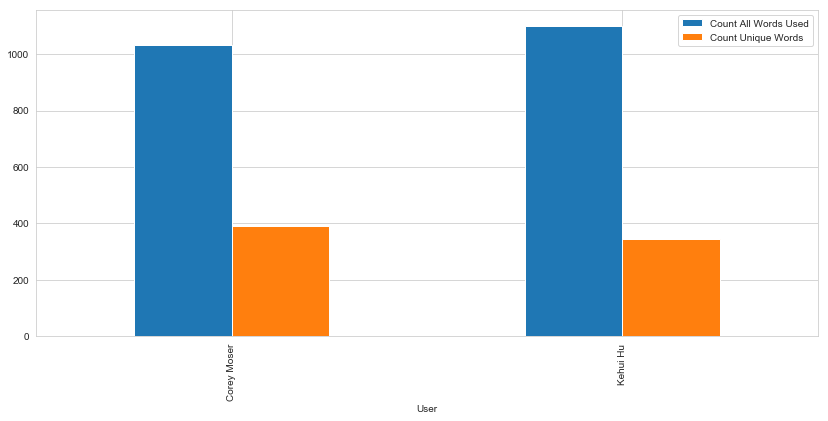

In [147]:
lexicography_df.plot(x="User", y=["Count All Words Used", "Count Unique Words"], kind="bar", figsize=(14,6))

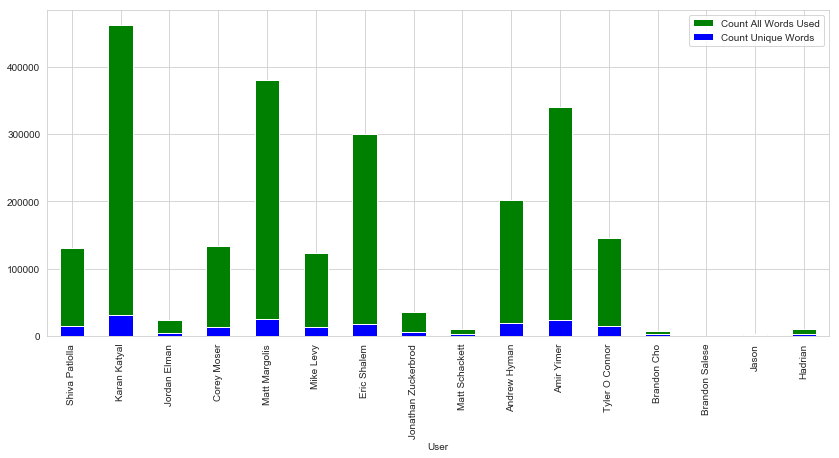

In [92]:
ax = lexicography_df.plot(x="User", y="Count All Words Used", kind="bar", color='green', figsize=(14,6))
lexicography_df.plot(x="User", y="Count Unique Words", kind="bar", ax=ax, color="blue")

## Wordcloud

### "Stopwords"

#### Stopwords are common words that need to be removed from consideration so we can see a meaningful analysis of the way each member uses language. Below is a sert of the common stopwords in English. I am going to create my own list of chat-specifc stop-words and extend the original list of stopwords

In [398]:
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

In [148]:
# Will add to this as more words become apparent 
chat_stopwords = ['yeah','will', 'didn', 'much', 'll', 'file attached', 'file', 'attached']

#This code will add the cabal_stopwords to our original list
STOPWORDS.update(chat_stopwords)

In [149]:
df.reset_index(inplace=True, drop=True)

In [150]:
df = df.drop(['index'],axis=1)

KeyError: "['index'] not found in axis"

In [151]:
df.head()

Date     Time         User  \
0  9/14/18  2:43 PM  Corey Moser   
1  9/14/18  2:43 PM  Corey Moser   
2  9/14/18  2:47 PM     Kehui Hu   
3  9/14/18  2:48 PM  Corey Moser   
4  9/14/18  2:58 PM     Kehui Hu   

                                             Message  \
0  Hey Kehui, the next time you're working on Ali...   
1  I know it might not be feasible everytime but ...   
2  No problem! I can also learn English from you ...   
3  I would be happy to practice english with you ...   
4  Thanks a lot, You are so nice! I am now at hom...   

                                        free_message  \
0  hey kehui the next time youre working on alix ...   
1  i know it might not be feasible everytime but ...   
2  no problem i can also learn english from you a...   
3  i would be happy to practice english with you ...   
4  thanks a lot you are so nice i am now at home ...   

                                   tokenized_message  number_of_words  \
0  [hey, kehui, the, next, time, youre, working, ...               29   
1  [i, know, it, might, not, be, feasible, everyt...               19   
2  [no, problem, i, can, also, learn, english, fr...               40   
3  [i, would, be, happy, to, practice, english, w...               53   
4  [thanks, a, lot, you, are, so, nice, i, am, no...               34   

   number_of_chars  
0              106  
1               76  
2              155  
3              228  
4              125

In [152]:
user_df

NameError: name 'user_df' is not defined

In [156]:
#Create a function to wordcloud each member's messages

def word_cloud_creator(user_name=''):
    import random
    from wordcloud import WordCloud, STOPWORDS
    '''
    Creates a word plot of the top 60 most used words by any given user. It assumes a pandas Dataframe with the needed data. 
    Input: Str. User's Name
    Output: Wordcloud plot of the most common words in that user's messages.
    '''
    
    #If no user is specified, select a random user from the user list
    if user_name == '':
        user_name = random.choice(user_list)
    
    #Create a df from the user specifed. Get the "free_message" column and convert all of the message to type string
    user_df = df[df['User'] == user_name]
    user_df.reset_index(drop=True, inplace=True)
    user_df['free_message'].apply(str)
    
    #Grab the User's name
    username = user_df['User'][0]
    
    #Create a corpus of user's messages
    user_corpus = " ".join(message for message in user_df['free_message'])
    
    #Update our default stopwords list with some of our own
    chat_stopwords = ['yeah','will', 'didn', 'much', 'll', 
                       'file attached', 'file', 'attached', 'thats', 'one', 'im', 'don','u200eimage', 'u200egif']
    STOPWORDS.update(chat_stopwords)
    
    #Create the wordcloud and figure
    wc = WordCloud(max_words=100, stopwords=STOPWORDS, background_color='white', margin=5, scale=3).generate(user_corpus)
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.title(f"{username}'s Wordcloud\nThere are {len(user_corpus)} words in {username}'s messages\n", 
              fontsize=30, loc ='left')
    
    return plt.imshow(wc, interpolation='bilinear')

#WILL RETURN TO THIS CODE
#     kinoa = []
#     for i, v in dp.lemmatize_words[dp.Character == name].items():
#         kinoa.extend(v)
#     kinoa_= Counter(kinoa)
#     wc = WordCloud(max_words =60,background_color='white', scale =3 , stopwords=set('one')).generate_from_frequencies(kinoa_)
#     plt.figure( figsize=(100,50) ).suptitle(name, fontsize=300)
#     plt.imshow(wc);


In [154]:
user_list

['Corey Moser', 'Kehui Hu']

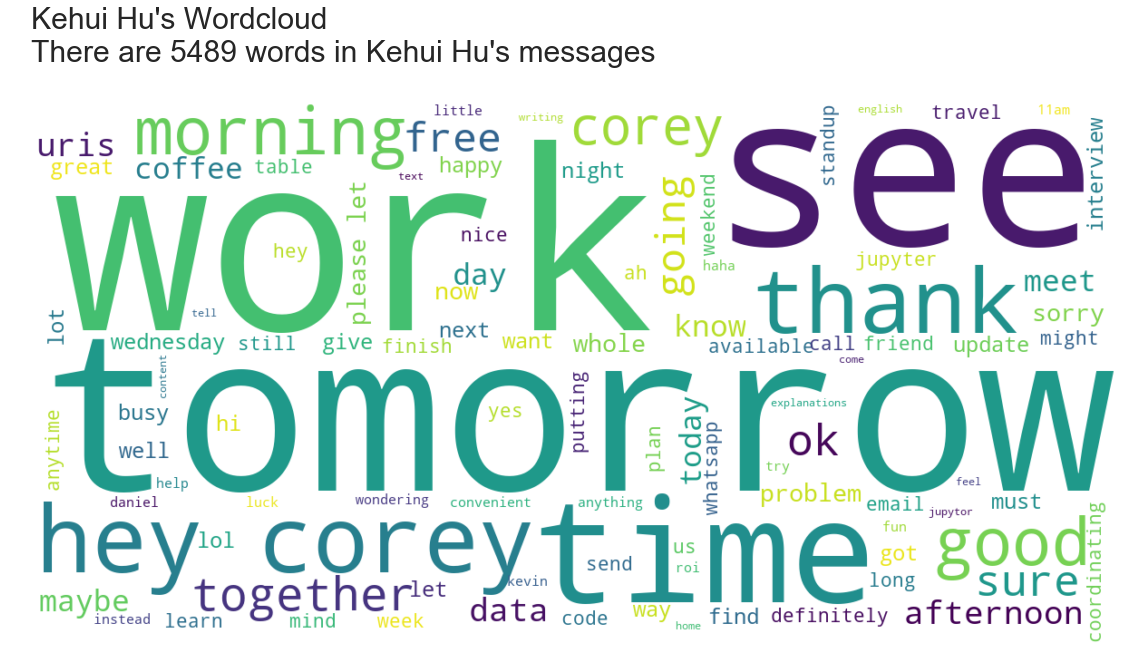

In [157]:
# Test 1: Input a user and return their word cloud
word_cloud_creator('Kehui Hu')

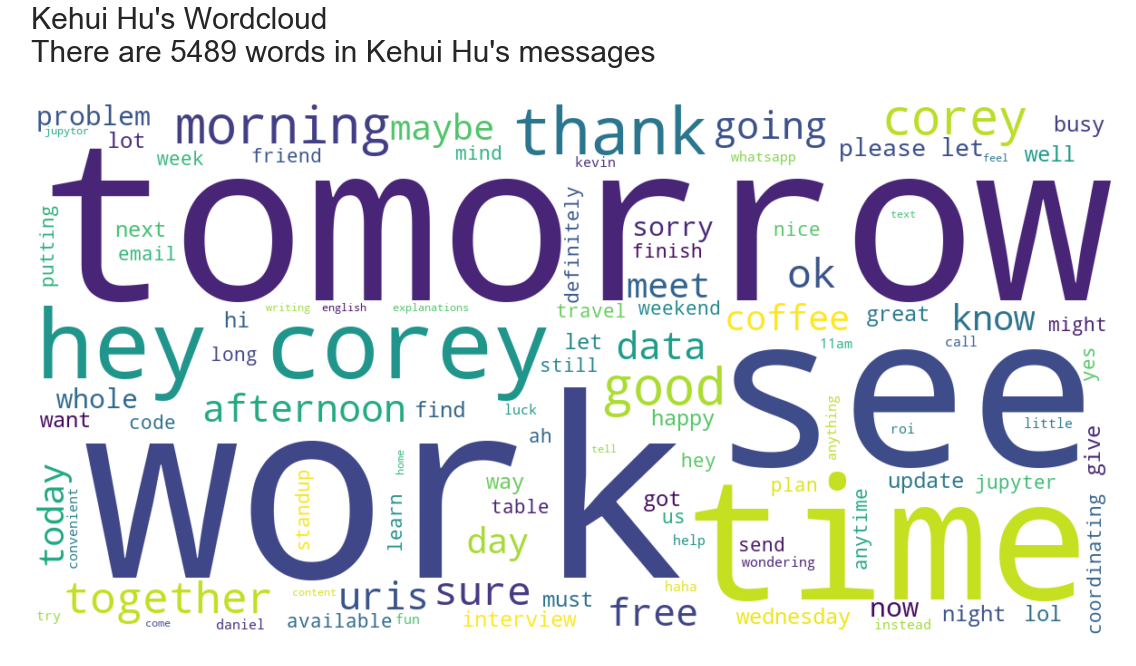

In [159]:
# Test 2: Input no user and return a random user's word cloud
word_cloud_creator()

In [162]:
all_user_corpus = " ".join(message for message in df['free_message'])

In [166]:
# all_user_corpus

### Create a wordcloud for the entire chat

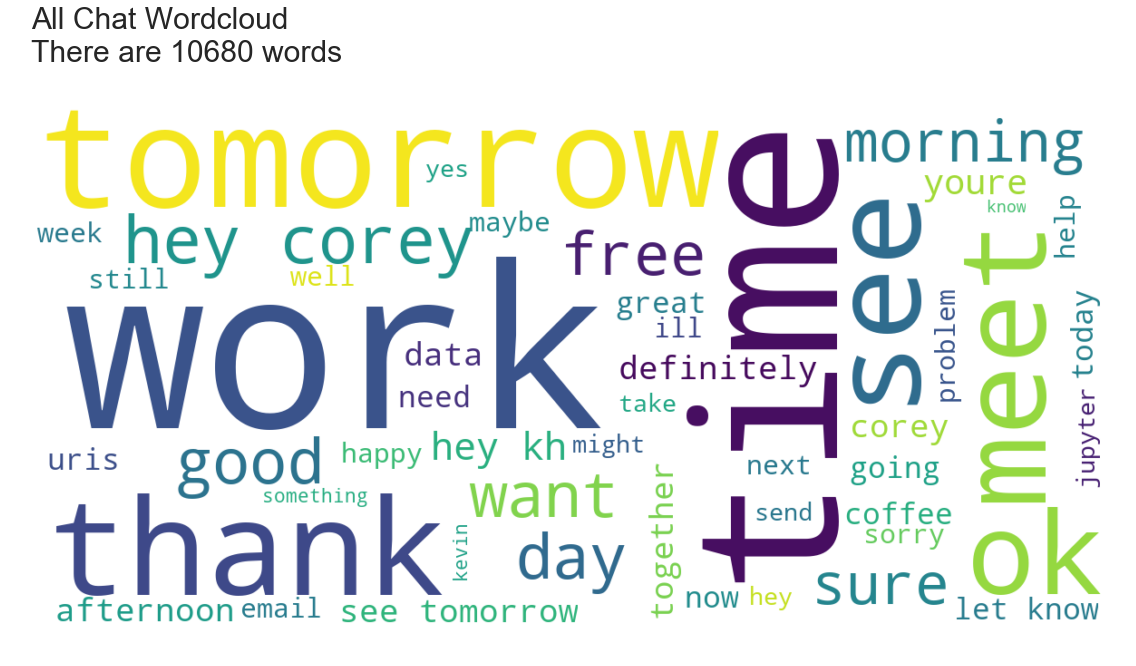

In [164]:
#Create the wordcloud and figure
wc = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white', margin=5, scale=3).generate(all_user_corpus)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title(f"All Chat Wordcloud\nThere are {len(all_user_corpus)} words\n", 
          fontsize=30, loc ='left')

plt.imshow(wc, interpolation='bilinear')

## Display a random message

In [165]:
df.head(n=2)

Date     Time         User  \
0  9/14/18  2:43 PM  Corey Moser   
1  9/14/18  2:43 PM  Corey Moser   

                                             Message  \
0  Hey Kehui, the next time you're working on Ali...   
1  I know it might not be feasible everytime but ...   

                                        free_message  \
0  hey kehui the next time youre working on alix ...   
1  i know it might not be feasible everytime but ...   

                                   tokenized_message  number_of_words  \
0  [hey, kehui, the, next, time, youre, working, ...               29   
1  [i, know, it, might, not, be, feasible, everyt...               19   

   number_of_chars  
0              106  
1               76

In [166]:
def random_message(user_name=''):
    nl = '\n'
    if user_name == '':
        random_message = df.sample(n=1)

        date = random_message.iloc[0]['Date']
        time = random_message.iloc[0]['Time']
        user = random_message.iloc[0]['User']
        message =random_message.iloc[0]['Message']
        
        output_string = f'Date: {date}{nl}Time: {time}{nl}User: {user}{nl}Message: {message}' 
        
        return print(output_string)

In [167]:
#Test out the code above
random_message()

Date: 3/12/19
Time: 3:15 PM
User: Kehui Hu
Message: Hey Corey, HR contacted me that she already got in touch with you. Thanks a lot. Please let me treat you to coffee or food when you have time:) Again good luck with interview!
